In [1]:
import numpy as np
import pandas as pd
import random

import os
import pickle
import sys
import timeit

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.datasets import make_spd_matrix
from sklearn.ensemble import RandomForestRegressor
from scipy.stats.stats import pearsonr 

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import FormatStrFormatter

from matplotlib.pyplot import imshow
import seaborn as sns

%matplotlib inline 

from IPython.display import Image 

from util import fit_IPTW_LR, fit_IPTW_RF, fit_IPTW_SVM
from util import sim_Data, sim_Unobs_Data, evaluation, bayes_unobs_confounder
import pickle

from util import *

<img src="split_treatment.png" width="400"/>

## Generate data with no-unobs. confounding

In [ ]:
xDim = 50
nSim = 10000

p_AgivenZ = 1
p_AgivenNotZ = 0.1
        
X_data, Y_data, A_data, nObs, Group_data, Y_0_data, Y_1_data, Z, A = sim_Data(xDim, nSim, p_AgivenZ, p_AgivenNotZ)

print('Fit IPTW + LR')
Yhat_0, Yhat_1 = fit_IPTW_LR(X_data, Y_data, A_data, nObs)
a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)

print('Fit IPTW + SVM')
Yhat_0, Yhat_1 = fit_IPTW_SVM(X_data, Y_data, A_data, nObs)
a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)

## Violation of Assumption 1: Generate data with unobs. confounding

In [ ]:
xDim = 50
nSim = 10000
p_AgivenZ = 1
p_AgivenNotZ = 0.1

X_data, Y_data, A_data, nObs, Group_data, Y_0_data, Y_1_data, Z, A = sim_Unobs_Data(xDim, nSim, p_AgivenZ, p_AgivenNotZ)
Yhat_0, Yhat_1 = fit_IPTW_LR(X_data, Y_data,A_data, nObs)
a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)

## Violation of Assumption 2: Generate data violating the split-treatment criterion 

In [ ]:
xDim = 50
nSim = 10000
p_AgivenZ = 0.6
p_AgivenNotZ = 0.7

X_data, Y_data, A_data, nObs, Group_data, Y_0_data, Y_1_data, Z, A = sim_Data(xDim, nSim, p_AgivenZ, p_AgivenNotZ)
Yhat_0, Yhat_1 = fit_IPTW_LR(X_data, Y_data, A_data, nObs)
a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)

# Refutation Analysis

### Generating Unobserved Confounders

In [ ]:
# Treatment: A_data; Features: X_data; Labels: Y_data [ Each of shape 10k*1 or 10k*50 ]
# A and A_data are the same

xDim = 50
nSim = 10000

A_matched_Z = []
RMSEs = []
A_matched_Z_unobs = []
RMSEs_unobs = []

corr_t=[]
corr_y=[]
counter=0
for p_AgivenZ in [0.6, 0.7, 0.8, 0.9, 1]:
    for p_AgivenNotZ in [0.5, 0.4, 0.3, 0.2, 0.1]:

        X_data, Y_data, A_data, nObs, Group_data, Y_0_data, Y_1_data, Z, A = sim_Data(xDim, nSim, p_AgivenZ, p_AgivenNotZ)
        print(np.sum(Y_0_data), np.sum(Y_1_data))
        
        #Generate Obs Refutation Data
        alpha= 1000
        eps= 10*alpha
        corr_treat, corr_out, X_data_unobs= bayes_unobs_confounder(X_data, A_data, Y_data, alpha, eps)
        corr_t.append(corr_treat)
        corr_y.append(corr_out)
        
        #Results on Normal Data
        Yhat_0, Yhat_1 = fit_IPTW_LR(X_data, Y_data, A_data, nObs)
        a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)
        
        A_matched_Z.append(a_matched_z)
        RMSEs.append(rmse)
        
        #Results on Confounded Data
        Yhat_0, Yhat_1 = fit_IPTW_LR(X_data_unobs, Y_data, A_data, nObs)
        a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)
        
        A_matched_Z_unobs.append(a_matched_z)
        RMSEs_unobs.append(rmse)
        
        
#         if counter ==0:
#             counter+=1
#             print(X_data.shape, Y_data.shape, A_data.shape, Group_data.shape, Y_0_data.shape, Y_1_data.shape)
#             print(Y_data[0], Y_0_data[0], Y_1_data[0], A[0])
#             print(Y_data[10], Y_0_data[10], Y_1_data[10], A[10])
#             print(A_data)
#             print(A, Z, nObs, len(A), len(Z))
            
#             if np.array_equal(A, A_data):
#                 print('Yes')
                
#             if np.array_equal(X_data, Group_data):
#                 print('Yes')
#             else:
#                 print('No')

corr_t=np.array(corr_t)
corr_y=np.array(corr_y)

print('Final')
print('Correlation Treatment: ', np.mean(corr_t), np.std(corr_t))
print('Correlation Outcome: ', np.mean(corr_y), np.std(corr_y))

### Results with True Data

In [ ]:
A_matched_Z = np.array(A_matched_Z)
RMSEs = np.array(RMSEs)
sort_indice = np.argsort(A_matched_Z)
plt.plot(A_matched_Z[sort_indice], RMSEs[sort_indice])
plt.xlabel('% of A matched Z')
plt.ylabel('RMSE')

### Results with Unobs Confounding

In [ ]:
A_matched_Z_unobs = np.array(A_matched_Z_unobs)
RMSEs_unobs = np.array(RMSEs_unobs)
sort_indice = np.argsort(A_matched_Z_unobs)
plt.plot(A_matched_Z_unobs[sort_indice], RMSEs_unobs[sort_indice])
plt.xlabel('% of A matched Z')
plt.ylabel('RMSE')

## Placebo Confounder

Avg compliance: 0.5999999999999999
560.4025206244025 837793.7358539576
p_A: 0.5001, IPTW: 1.00 +/- 0.07
Est. Y_0 RMSE: 0.01418078579966871
Est. Y_1 RMSE: 0.2518455492106607
80.2% A matched Z, RMSE: 0.18
% of A matched Z 0.8023
(array([0., 1.]), array([4891, 5109]))
p_A: 0.5109, IPTW: 1.00 +/- 0.07
Est. Y_0 RMSE: 0.39691563698847504
Est. Y_1 RMSE: 42.55500800805432
80.2% A matched Z, RMSE: 1.13


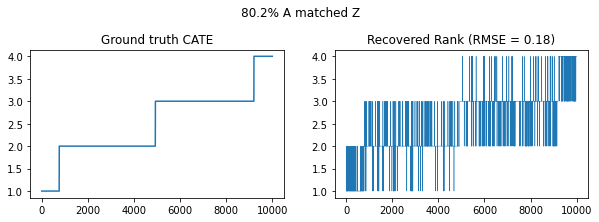

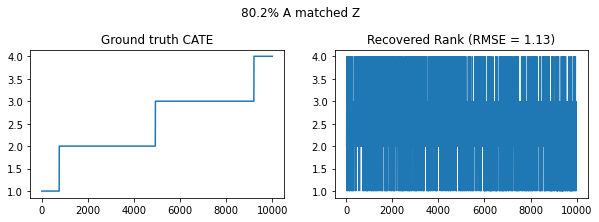

In [7]:
xDim = 50
nSim = 10000

#Data Generation
A_matched_Z = []
RMSEs = []

# A percentage Z match 52% params
# p_AgivenZ= 0.6
# p_AgivenNotZ=0.5

# A percentage Z match 77% params
p_AgivenZ= 0.8
p_AgivenNotZ=0.2

X_data, Y_data, A_data, nObs, Group_data, Y_0_data, Y_1_data, Z, A = sim_Data(xDim, nSim, p_AgivenZ, p_AgivenNotZ)
print(np.sum(Y_0_data), np.sum(Y_1_data))

#Yhat_0, Yhat_1 = fit_IPTW_LR(X_data, Y_data, A_data, nObs)
Yhat_0, Yhat_1 = fit_IPTW_SVM(X_data, Y_data, A_data, nObs)

a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)
print('% of A matched Z', a_matched_z)

A_matched_Z.append(a_matched_z)
RMSEs.append(rmse)

#Placebo Confounder
A_matched_Z_unobs = []
RMSEs_unobs = []

A_data_placebo= placebo_confounder(X_data, A_data, Y_data)

#Results on Confounded Data
Yhat_0, Yhat_1 = fit_IPTW_LR(X_data, Y_data,  A_data_placebo, nObs)
a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)

A_matched_Z_unobs.append(a_matched_z)
RMSEs_unobs.append(rmse)

## Sweep over Unobs Confounders

In [ ]:
methods=['IPTW_LR', 'IPTW_SVM']
res=[]
for method in methods:

    alpha_range, sort_indice, a_matched_z, A_matched_Z_unobs, RMSEs_unobs, RMSEs, corr_t, corr_y= refutation_analysis(method)

    A_matched_Z_unobs = np.array(A_matched_Z_unobs)
    RMSEs_unobs = np.array(RMSEs_unobs)

    sort_indice = np.argsort(A_matched_Z_unobs)
    sort_indice = sort_indice[::-1]
    
    res.append(RMSEs_unobs)

## Bar Plot

In [ ]:
plot_df= pd.DataFrame(columns=methods)
for idx in range(len(methods)):
    plot_df[methods[idx]]= res[idx]

sns.set(font_scale=2.45)
sns.set_style("whitegrid")
#sns.set(rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white")

fig, ax1 = plt.subplots(figsize = [15,7])

fig = sns.boxplot(data = plot_df, palette='PRGn')
fig.set_xlabel('Models')
fig.set_ylabel('RMSE')
plt.savefig('images/sensitivity_analysis_synthetic.png', dpi=200)

## Line Plots

In [ ]:
plt.plot(alpha_range[sort_indice], RMSEs_unobs[sort_indice], '-ok', label='Confounder-SVM')
plt.plot(alpha_range[sort_indice], len(alpha_range)*RMSEs, label='No Confounder-SVM')
plt.xlabel('Confounder Strength (10^4/alpha)')
plt.ylabel('RMSE')
plt.title('Refutation analysis with % of A matched Z ' + str(np.round(a_matched_z,2)))
plt.legend()
plt.savefig('images/lr.jpg')

In [ ]:
plt.plot(alpha_range, corr_t, '-ok')
plt.xlabel('Confounder Strength (10^4/alpha)')
plt.ylabel('Pearson Correlation')
plt.title('Correlation of Confounder with Treatment A')
#plt.savefig('images/b_52.jpg')

In [ ]:
plt.plot(alpha_range, corr_y, '-ok')
plt.xlabel('Confounder Strength (10^4/alpha)')
plt.ylabel('Pearson Correlation')
plt.title('Correlation of Confounder with Outcome Y')
#plt.savefig('images/c_52.jpg')